In [14]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from glob import glob
import itertools
from copy import deepcopy
import os.path as op

# Statistics
from tslearn import barycenters
from scipy.stats import wasserstein_distance

# Classification
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedGroupKFold, cross_validate, StratifiedKFold, LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline

# add path to classification analysis functions
from mixed_sigmoid_normalisation import MixedSigmoidScaler

# Add ../data_visualization to path, then import kl_divergence_from_counts
# add path to classification analysis functions
sys.path.insert(0, './data_visualization/')
from kl_divergence_from_counts import kl_divergence_from_counts

# Add rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [15]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [ ]:
# Define base_repo as one level up from current directory
base_repo = op.dirname(op.abspath(''))
plot_dir = f"{base_repo}/data_visualization/plots/"

# load pyspi SPI info
pyspi_SPI_info = pd.read_csv(f"{base_repo}/functional_connectivity_analysis/pyspi_SPI_info.csv")
functional_connectivity_measures_dir = f"{base_repo}/data/empirical/functional_connectivity_measures/"
classification_res_path = f"{base_repo}/data/empirical/stimulus_decoding_classification/"

# Modeling results
simulated_TS_dir = f'{base_repo}/data/model/simulated_data/'
model_barycenter_dir = f'{base_repo}/data/model/barycenter_results/'

# Initialize list for pyspi results
all_time_resolved_barycenter_res_list = []

# Load in time-resolved barycenter results
for barycenter_time_res_file in glob(f"{functional_connectivity_measures_dir}/*pyspi_barycenter_sq*.csv"):
    barycenter_time_resolved_res = pd.read_csv(barycenter_time_res_file)
    all_time_resolved_barycenter_res_list.append(barycenter_time_resolved_res)

# Concatenate pyspi results
all_time_resolved_barycenter_res = pd.concat(all_time_resolved_barycenter_res_list)

# Separate out into raw and absolute value time series and make sure SPI ends with "_max"
all_raw_time_resolved_barycenter_res = all_time_resolved_barycenter_res.query("Data_Type=='Raw' & SPI.str.endswith('_max')")
all_abs_time_resolved_barycenter_res = all_time_resolved_barycenter_res.query("Data_Type=='Abs' & SPI.str.endswith('_max')")


## Robustness check 1: stimulus classification with raw vs. absolute value time series before computing barycenter

In [17]:
# Define classifier
model = LogisticRegression(penalty='l1', C=1, solver='liblinear', class_weight='balanced', random_state=127)

pipe = Pipeline([('scaler', MixedSigmoidScaler(unit_variance=True)), 
                            ('model', model)])

# Define scoring type
scoring = {'accuracy': 'accuracy',
           'balanced_accuracy': 'balanced_accuracy',
           'AUC': make_scorer(roc_auc_score, response_method='predict_proba')}

# meta-ROI comparisons
meta_ROIs = ["Category_Selective", "IPS", "Prefrontal_Cortex", "V1_V2"]

# Manually define combinations
meta_roi_comparisons = [("Category_Selective", "IPS"),
                        ("Category_Selective", "Prefrontal_Cortex"),
                        ("Category_Selective", "V1_V2"),
                        ("IPS", "Category_Selective"),
                        ("Prefrontal_Cortex", "Category_Selective"),
                        ("V1_V2", "Category_Selective")]

# Relevance type comparisons
relevance_type_comparisons = ["Relevant non-target", "Irrelevant"]

# Stimulus presentation comparisons
stimulus_presentation_comparisons = ["on", "off"]

# Define all combinations for cross-task classification
group_stratified_CV = StratifiedGroupKFold(n_splits = 10, shuffle = True, random_state=127)

def impute_helper(this_statistic_data, num_rows):
    # Extract SPI values and fix NaN
    this_raw_column_data = this_statistic_data['value']
    num_NaN = this_raw_column_data.isna().sum()
    prop_NaN = num_NaN / num_rows

    # If 0% < num_NaN < 10%, impute by the mean of each component
    if 0 < prop_NaN < 0.1:
        values_imputed = (this_raw_column_data
                            .transform(lambda x: x.fillna(x.mean())))

        this_raw_column_data = values_imputed
        this_statistic_data["value"] = this_raw_column_data

    return this_statistic_data

In [18]:
# Stimulus type comparisons
stimulus_types = all_raw_time_resolved_barycenter_res.stimulus_type.unique().tolist()
stimulus_type_comparisons = list(itertools.combinations(stimulus_types, 2))

# All comparisons list
comparing_between_stimulus_types_classification_results_list = []

for relevance_type in relevance_type_comparisons:
    for stimulus_presentation in stimulus_presentation_comparisons:

        # First, look at each meta-ROI pair separately# First, look at each meta-ROI pair separately
        for meta_roi_comparison in meta_roi_comparisons:
            ROI_from, ROI_to = meta_roi_comparison

            # Finally, we get to the final dataset
            roi_pair_wise_dataset_for_classification = (all_abs_time_resolved_barycenter_res.query("meta_ROI_from==@ROI_from & meta_ROI_to==@ROI_to & relevance_type == @relevance_type & stimulus_presentation == @stimulus_presentation")
                                                        .reset_index(drop=True))
            
            

In [ ]:
# All comparisons list
n_jobs = 1
comparing_between_stimulus_types_classification_results_list = []

for relevance_type in relevance_type_comparisons:
    print("Relevance type:" + str(relevance_type))
    for stimulus_presentation in stimulus_presentation_comparisons:
        print("Stimulus presentation:" + str(stimulus_presentation))

        # First, look at each meta-ROI pair separately# First, look at each meta-ROI pair separately
        for meta_roi_comparison in meta_roi_comparisons:
            print("ROI Comparison:" + str(meta_roi_comparison))
            ROI_from, ROI_to = meta_roi_comparison

            # Finally, we get to the final dataset
            roi_abs_pair_wise_dataset_for_classification = (all_abs_time_resolved_barycenter_res.query("meta_ROI_from==@ROI_from & meta_ROI_to==@ROI_to & relevance_type == @relevance_type & stimulus_presentation == @stimulus_presentation")
                                                        .reset_index(drop=True))
            
            roi_raw_pair_wise_dataset_for_classification = (all_raw_time_resolved_barycenter_res.query("meta_ROI_from==@ROI_from & meta_ROI_to==@ROI_to & relevance_type == @relevance_type & stimulus_presentation == @stimulus_presentation")
                                                        .reset_index(drop=True))
            
            for this_SPI in roi_abs_pair_wise_dataset_for_classification.SPI.unique():
                    print(f"Processing {this_SPI}")

                    # Extract this SPI
                    this_raw_statistic_data = roi_raw_pair_wise_dataset_for_classification.query(f"SPI == '{this_SPI}'")
                    this_abs_statistic_data = roi_abs_pair_wise_dataset_for_classification.query(f"SPI == '{this_SPI}'")

                    # Find overall number of rows
                    num_rows = this_raw_statistic_data.shape[0]

                    # Imputation
                    this_raw_statistic_data = impute_helper(this_raw_statistic_data, num_rows)
                    this_abs_statistic_data = impute_helper(this_abs_statistic_data, num_rows)
                    
                    # Start an empty list for the classification results
                    stat_combo_res_list = []
                
                    # Iterate over stimulus combos
                    for this_combo in stimulus_type_comparisons:

                        # Subset data to the corresponding stimulus pairs
                        final_raw_dataset_for_classification_this_combo = this_raw_statistic_data.query(f"stimulus_type in {this_combo}")
                        final_abs_dataset_for_classification_this_combo = this_abs_statistic_data.query(f"stimulus_type in {this_combo}")

                        # Fit classifier
                        X_raw = final_raw_dataset_for_classification_this_combo.value.to_numpy().reshape(-1, 1)
                        y_raw = final_raw_dataset_for_classification_this_combo.stimulus_type.to_numpy().reshape(-1, 1)
                        groups_raw = final_raw_dataset_for_classification_this_combo.subject_ID.to_numpy().reshape(-1, 1)
                        groups_raw_flat = np.array([str(item[0]) for item in groups_raw])

                        X_abs = final_abs_dataset_for_classification_this_combo.value.to_numpy().reshape(-1, 1)
                        y_abs = final_abs_dataset_for_classification_this_combo.stimulus_type.to_numpy().reshape(-1, 1)
                        groups_abs = final_abs_dataset_for_classification_this_combo.subject_ID.to_numpy().reshape(-1, 1)
                        groups_abs_flat = np.array([str(item[0]) for item in groups_abs])

                        # Make a deepcopy of the pipeline
                        this_iter_pipe_raw = deepcopy(pipe)
                        this_classifier_res_raw = cross_validate(this_iter_pipe_raw, X_raw, y_raw, groups=groups_raw_flat, cv=group_stratified_CV, scoring=scoring, n_jobs=n_jobs, 
                                                                    return_estimator=False, return_train_score=False)
                        this_SPI_combo_df_raw = pd.DataFrame({"SPI": [this_SPI], 
                                "classifier": ["Logistic Regression"],
                                "Data_Type": ['Raw'],
                                "Region_Pair": [f"{ROI_from}__{ROI_to}"],
                                "relevance_type": [relevance_type],
                                "stimulus_presentation": [stimulus_presentation],
                                "stimulus_combo": [this_combo], 
                                "accuracy": [this_classifier_res_raw['test_accuracy'].mean()],
                                "accuracy_SD": [this_classifier_res_raw['test_accuracy'].std()]})
                        
                        # Append to growing results list
                        comparing_between_stimulus_types_classification_results_list.append(this_SPI_combo_df_raw)
                        
                        this_iter_pipe_abs = deepcopy(pipe)
                        this_classifier_res_abs = cross_validate(this_iter_pipe_abs, X_abs, y_abs, groups=groups_abs_flat, cv=group_stratified_CV, scoring=scoring, n_jobs=n_jobs, 
                                                                    return_estimator=False, return_train_score=False)
                        this_SPI_combo_df_abs = pd.DataFrame({"SPI": [this_SPI],
                                "classifier": ["Logistic Regression"],
                                "Data_Type": ['Abs'],
                                "Region_Pair": [f"{ROI_from}__{ROI_to}"],
                                "relevance_type": [relevance_type],
                                "stimulus_presentation": [stimulus_presentation],
                                "stimulus_combo": [this_combo], 
                                "accuracy": [this_classifier_res_abs['test_accuracy'].mean()],
                                "accuracy_SD": [this_classifier_res_abs['test_accuracy'].std()]})
                        
                        # Append to growing results list
                        comparing_between_stimulus_types_classification_results_list.append(this_SPI_combo_df_abs)
                        

comparing_between_stimulus_types_classification_results = pd.concat(comparing_between_stimulus_types_classification_results_list).reset_index(drop=True)


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "stimulus_combo". Fall back to string conversion. The error is: <class 'tuple'>
  warnings.warn('Error while trying to convert '


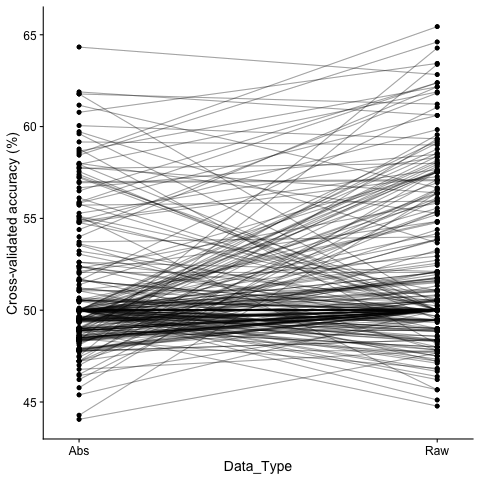

In [19]:
%%R -i comparing_between_stimulus_types_classification_results,plot_dir

comparing_between_stimulus_types_classification_results %>% 
    mutate(stat_identifier = glue("{SPI}_{Region_Pair}_{relevance_type}_{stimulus_presentation}_{stimulus_combo}")) %>%
    ggplot(data=., mapping=aes(x=Data_Type, y=100*accuracy)) +
    ylab("Cross-validated accuracy (%)") +
    scale_x_discrete(expand=c(0.05, 0.05)) +
    geom_line(aes(group=stat_identifier), color="black", alpha=0.2)  +
    geom_point() 
# ggsave(glue("{plot_dir}/modeling/Barycenter_empirical_performance_abs_vs_raw.svg"), width=3.5, height=4, units='in', dpi=300)

## Robustness check 2: model vs. empirical alignment with different geometries

In [20]:
# Separate out into raw and absolute value time series and make sure SPI ends with "_max"
all_abs_time_resolved_barycenter_res = (all_time_resolved_barycenter_res
                                        .query("Data_Type=='Abs' & SPI.str.endswith('_max_time') & meta_ROI_from == 'Category_Selective' & meta_ROI_to in ['V1_V2', 'Prefrontal_Cortex']")
                                        .assign(SPI = lambda x: x['SPI'].str.replace('_max_time', '').str.replace('_max', ''),
                                                Model = lambda x: np.where(x.meta_ROI_to == 'V1_V2', 'IIT', 'GNWT'))
)

# Load modeling results
all_model_pyspi_res_list = []
for noise_level in [1]:
    GNWT_stim_on_pyspi_barycenter_res = pd.read_csv(f"{model_barycenter_dir}/GNWT_stim_on_sims_all_pyspi_barycenter_sq_results_noise_{noise_level}.csv")
    GNWT_stim_off_pyspi_barycenter_res = pd.read_csv(f"{model_barycenter_dir}/GNWT_stim_off_sims_all_pyspi_barycenter_sq_results_noise_{noise_level}.csv")
    IIT_stim_on_pyspi_barycenter_res = pd.read_csv(f"{model_barycenter_dir}/IIT_stim_on_sims_all_pyspi_barycenter_sq_results_noise_{noise_level}.csv")
    IIT_stim_off_pyspi_barycenter_res = pd.read_csv(f"{model_barycenter_dir}/IIT_stim_off_sims_all_pyspi_barycenter_sq_results_noise_{noise_level}.csv")

    noise_level_pyspi_res = (pd.concat([GNWT_stim_on_pyspi_barycenter_res,
                                        GNWT_stim_off_pyspi_barycenter_res,
                                        IIT_stim_on_pyspi_barycenter_res,
                                        IIT_stim_off_pyspi_barycenter_res])
                            .query("meta_ROI_from == 'Category_Selective'")
                            .assign(SPI_stat = lambda x: np.where(x['SPI'].str.contains('_max_time'), 'max_time', 'max'),
                                    SPI = lambda x: x['SPI'].str.replace('_max_time', '').str.replace('_max', ''),
                                    Model = lambda x: x['sim_context'].str.split('_stim').str[0],
                                    stimulus_presentationulus_Presentation = lambda x: x['sim_context'].str.split('stim_').str[1])
                            .rename(columns={'stimulus_presentationulus_Presentation': 'stimulus_presentation'})
                            .drop(columns=['sim_context'])
                            .query("SPI_stat=='max_time' & Data_Type == 'Abs'")
    )

    # Add noise column if it doesn't exist
    if 'Noise' not in noise_level_pyspi_res.columns:
        noise_level_pyspi_res['Noise'] = noise_level
    else:
        noise_level_pyspi_res = noise_level_pyspi_res.query("Noise==@noise_level")

    # Append to list
    all_model_pyspi_res_list.append(noise_level_pyspi_res)

# Concatenate results
all_model_pyspi_res = pd.concat(all_model_pyspi_res_list)


# Combine
model_vs_empirical_across_geometries = pd.concat([all_abs_time_resolved_barycenter_res.assign(Data_Type = "Empirical"), all_model_pyspi_res.assign(Data_Type = "Model")])

In [21]:
# Compute the KL divergence between the model and empirical data
all_KL_results_list = []
all_WD_results_list = []
noise_level = 1
for model in ["GNWT", "IIT"]:
    for this_SPI in model_vs_empirical_across_geometries.SPI.unique():
        for stim_type in ['on', 'off']:
        
            # Subset data
            empirical_data_abs = model_vs_empirical_across_geometries.query("SPI==@this_SPI & stimulus_presentation == @stim_type & Model == @model & Data_Type == 'Empirical'")['value']
            model_data_abs = model_vs_empirical_across_geometries.query("SPI==@this_SPI & stimulus_presentation == @stim_type & Model == @model & Data_Type == 'Model' & Noise==@noise_level")['value']

            #### KL ####
            # Absolute value data
            this_model_noise_KL_abs = kl_divergence_from_counts(empirical_data_abs, model_data_abs, num_bins=100, units="bits")
            all_KL_results_list.append(pd.DataFrame({"Model": [model], "SPI": [this_SPI], "stimulus_presentation": [stim_type], "Noise": [noise_level], "Data_Type": ["Abs"], "KL_Divergence": [this_model_noise_KL_abs]}))

            #### Wasserstein Distance ####
            # Absolute value data
            this_model_noise_WD_abs = wasserstein_distance(empirical_data_abs, model_data_abs)
            all_WD_results_list.append(pd.DataFrame({"Model": [model], "SPI": [this_SPI], "stimulus_presentation": [stim_type], "Noise": [noise_level], "Data_Type": ["Abs"], "WD": [this_model_noise_WD_abs]}))

# Concatenate the results
all_KL_results = pd.concat(all_KL_results_list)
all_WD_results = pd.concat(all_WD_results_list)

# Merge the KL and WD results
all_stats_results = pd.merge(all_KL_results, all_WD_results, on=['Model', 'SPI', 'stimulus_presentation', 'Noise', 'Data_Type'])
all_stats_results.query("Noise == 1").sort_values(['Data_Type', 'Model'])

,Model,SPI,stimulus_presentation,Noise,Data_Type,KL_Divergence,WD
0,GNWT,bary-sq_euclidean,on,1,Abs,0.255326,29.592465
1,GNWT,bary-sq_euclidean,off,1,Abs,0.242102,19.976732
2,GNWT,bary-sq_dtw,on,1,Abs,0.275402,32.005531
3,GNWT,bary-sq_dtw,off,1,Abs,0.194692,25.702917
4,GNWT,bary-sq_sgddtw,on,1,Abs,0.258433,38.282968
5,GNWT,bary-sq_sgddtw,off,1,Abs,0.213728,33.674600
6,GNWT,bary-sq_softdtw,on,1,Abs,0.253630,43.050746
7,GNWT,bary-sq_softdtw,off,1,Abs,0.183751,22.758272
8,IIT,bary-sq_euclidean,on,1,Abs,3.226740,103.450863
9,IIT,bary-sq_euclidean,off,1,Abs,0.604928,65.735972


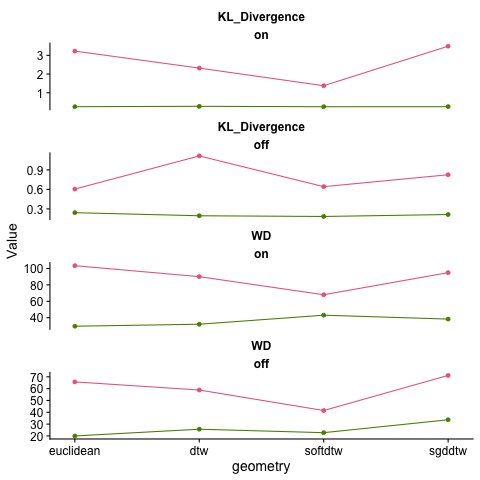

In [22]:
%%R -i all_stats_results

all_stats_results %>% 
    pivot_longer(cols=c(KL_Divergence, WD), names_to="Statistic", values_to="Value") %>%
    mutate(stimulus_presentation = factor(stimulus_presentation, levels=c("on", "off")),
           geometry = str_replace(SPI, "bary-sq_", "")) %>%
    mutate(geometry = factor(geometry, levels=c("euclidean", "dtw", "softdtw", "sgddtw"))) %>%
    ggplot(data=., mapping=aes(x=geometry, y=Value, color=Model)) +
    geom_point() +
    geom_line(aes(group=Model)) +
    scale_color_manual(values=c("IIT" = "#e96893", "GNWT" = "#5b8c00")) +
    facet_wrap(Statistic ~ stimulus_presentation, scales='free_y', ncol=1) +
    scale_x_discrete(expand=c(0.05, 0.05)) +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

# ggsave(glue("{plot_dir}/modeling/Barycenter_KL_WD_across_geometries.svg"), width=4, height=5, units='in', dpi=300)